# Stage 2: Data Annotation

In this notebook, several Large Language Model (LLM) are tested to perform sentiment annotation on the ESG document dataset, assigning scores of 0 for negative, 0.5 for neutral, and 1 for positive sentiment.  
The workflow involves manually creating a "gold standard" by annotating ~500 sentences, afterward setting up 2-3 LLMs for trial annotations, and experimenting with prompting strategies (zero-shot/few-shot) that we'll evaluate against the "gold standard".

## Setup & Data Loading

In [147]:
# Imports
import os
import re
import ast
import time
import pandas as pd
import numpy as np
import openai
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import pipeline
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
tqdm.pandas()

In [148]:
# Load the preprocessed data
cleaned_data = pd.read_csv('../data/checkpoints/enriched_cleaned_data.csv', delimiter = '|')

In [149]:
# Define a function to convert a string representation of a list to a list datatype
def string_to_list(string):
    try:
        return ast.literal_eval(string)
    except (ValueError, SyntaxError):
        print('List conversion failed')
        return []

def set_datatypes(df):
    # Convert the string representations of the lists to the correct 'list' datatype
    df['word_tokens'] = df['word_tokens'].apply(string_to_list)
    df['sentence_tokens'] = df['sentence_tokens'].apply(string_to_list)
    df['pos_tagged_word_tokens'] = df['pos_tagged_word_tokens'].apply(string_to_list)
    df['pos_tagged_sentence_tokens'] = df['pos_tagged_sentence_tokens'].apply(string_to_list)
    df['esg_topics'] = df['esg_topics'].apply(string_to_list)
    
    # Convert date to correct datatype
    df['date'] = pd.to_datetime(df['date'])

    # Derive year and month to aggregate
    df['year_month'] = df['date'].apply(lambda x: x.strftime('%Y-%m'))
    df['year'] = df['date'].apply(lambda x: x.strftime('%Y'))
    df['month'] = df['date'].apply(lambda x: x.strftime('%m'))

    return df

In [150]:
# Set the correct datatypes, e.g. lists and datetime
cleaned_data = set_datatypes(cleaned_data)

In [151]:
# Define function to save intermediary steps in a file
def csv_checkpoint(df, filename='checkpoint'):
    """
    Saves a DataFrame to a CSV file and loads it back into a DataFrame.

    Args:
        df (pandas.DataFrame): The DataFrame to save and load.
        filename (str): The name of the CSV file to save the DataFrame to (default: 'checkpoint').

    Returns:
        pandas.DataFrame: The loaded DataFrame.
    """
    if not os.path.exists('./checkpoints/'):  # Check if the directory exists and create it if it doesn't
        os.makedirs('./checkpoints/')

    # Save DataFrame to CSV
    df.to_csv(f'./checkpoints/{filename}.csv', index=False, sep='|')  # Save DataFrame to CSV with specified filename
    print(f'Saved DataFrame to {filename}.csv')

    # Load CSV back into DataFrame
    df = pd.read_csv(f'./checkpoints/{filename}.csv', delimiter='|')  # Load CSV back into DataFrame
    print(f'Loaded DataFrame from {filename}.csv')

    return df

## Manual sentence sentiment annotation

To define a "gold standard" for the sentiment, 500 randomly sampled sentences are manually annotate with:  
**0 = negative, 0.5 = neutral, 1 = positive**

In [200]:
# Crate a deep copy so no reload from CSV files is necessary is something goes wrong
documents = cleaned_data.copy(deep=True)

In [201]:
# Explode the dataset based on the sentence tokens, so each row contains one sentence
documents = documents.explode('sentence_tokens')

# Drop rows with no sentence
documents = documents.dropna(subset=['sentence_tokens'])
documents = documents[documents['sentence_tokens'].str.strip() != '']

# Preserve original index, so a later aggregation is possible but rows have unique index
documents['original_index'] = documents.index

# Reset the index
documents = documents.reset_index(drop=True)

The ratio of internal and external documents is quite imbalanced (see EDA).  
Therefore an oversampling for interal sentences is considered to get a ratio of 20/80 (internal/external) sentences.

In [202]:
# Separate the DataFrame into internal/external sentences with a defined ratio
internal = documents[documents['internal'] == 1]
external = documents[documents['internal'] == 0]

# Determine the number of samples from each group, 1000 sentences in total
n_internal = int(0.2 * 1000)  # 20% of samples
n_external = 1000 - n_internal  # Remaining samples

# Sample 1000 random sentences with a seed, so a re-run samples the same sentences
sampled_internal = internal.sample(n=n_internal, random_state=42)
sampled_external = external.sample(n=n_external, random_state=42)

# Concatenate and shuffle the samples the DataFrames, reset the index
sampled_documents = pd.concat([sampled_internal, sampled_external])
sampled_documents = sampled_documents.sample(frac=1, random_state=42)
sampled_documents = sampled_documents.reset_index(drop=True)

In [203]:
# Craete new column to store the sentence sentiment
sampled_documents['sentiment_manual'] = np.nan

annotate = input("Do you want to annotate? (y/n): ")
annotate = True if annotate.lower() == 'y' else False

if not annotate:
    gold_standard = pd.read_csv('./annotated/gold_standard.csv', delimiter = '|')
    if 'sentiment_manual' in gold_standard.columns:
        sampled_documents['sentiment_manual'] = gold_standard['sentiment_manual']
        print("Gold standard loaded")
    else:
        print("'sentiment_manual' column not found in the CSV file.")
else:
    print("Will start annotating...")

Will start annotating...


In [204]:
# Check the sampled data
sampled_documents[['title','sentence_tokens','internal','sentiment_manual']].head()

,title,sentence_tokens,internal,sentiment_manual
0,The Room Where It Happens: A quiet summer for ...,see please check junk folder,0,NaN
1,PRESS RELEASE: E.ON SE: E.ON delivers strong f...,primary reasons cooler weather first half oper...,0,NaN
2,Automotive Over-the-Air ( OTA) Market to Garne...,interested procure data actionable strategy in...,0,NaN
3,"At 11.2% CAGR, Global Herbal Medicine Market S...",rising number patients suffering chronic illne...,0,NaN
4,Nordic Nanovector ASA Announces Proposed Board...,nhl indication substantial unmet medical need ...,0,NaN


Within a loop, all sentences are manually annotated.  
With a "+" a sentence is flagged as positive (1.0), a "-" marks a negative (0.0) sentence and "Enter" (no value) flags the sentence as neutral (0.5).

In [205]:
if annotate:

    # Loop the samples to annotate them
    for idx, row in sampled_documents.iterrows():
        # Loop until valid input is received
        while True:
            # Print the title of the document and the sentence
            print(f"Title: {row['title']}\nSentence Nr. {idx}: {row['sentence_tokens']}\n")

            # Wait for user input
            sentiment = input("Enter sentiment value (+ for 1.0, - for 0.0, Enter for 0.5): ")

            # Check if the input is valid
            if sentiment == '+':
                sampled_documents.at[idx, 'sentiment_manual'] = 1.0
                break
            elif sentiment == '-':
                sampled_documents.at[idx, 'sentiment_manual'] = 0.0
                break
            elif sentiment == '':
                sampled_documents.at[idx, 'sentiment_manual'] = 0.5
                break
            else:
                print("Invalid input. Please try again.")

Title: The Room Where It Happens: A quiet summer for lobbyists? Nope
Sentence Nr. 0: see please check junk folder



KeyboardInterrupt: Interrupted by user

*Print outs of all sentences deleted due to readability of the notebook*

In [13]:
# Save the manual annotations to CSV (whole dataframe is too big to store on GitHub, therefore only sentences and manual annotations are stored)
if not os.path.exists('./annotated/'):  # Check if the directory exists and create it if it doesn't
    os.makedirs('./annotated/')
sampled_documents[['sentiment_manual', 'sentence_tokens']].to_csv(f'./annotated/gold_standard.csv', index=False, sep='|')

csv_checkpoint(sampled_documents, 'sampled_documents');

Saved DataFrame to sampled_documents.csv
Loaded DataFrame from sampled_documents.csv


In [14]:
# Check the manually annotated data
sampled_documents[sampled_documents['sentiment_manual'].notnull()].head()

,company,datatype,date,domain,esg_topics,internal,symbol,title,cleaned_content,word_tokens,...,pos_tagged_sentence_tokens,market_cap_in_usd_b,sector,industry,sentiment_value,year_month,year,month,original_index,sentiment_manual
529113,Qiagen,thinktank,2022-03-17,thelancet,"[GenderDiversity, Privacy]",0,QIA,Transcript levels in plasma contribute substan...,aa remain underrepresented alzheimers disease ...,"[aa, remain, underrepresented, alzheimers, dis...",...,"[[(aa, NN), (remain, VBP), (underrepresented, ...",11.38,Healthcare,Diagnostics & Research,0.100772,2022-03,2022,03,7601,0.0
339673,Beiersdorf,general,2021-04-27,cyclingweekly,"[Compliance, Recycling, CustomerService, Gende...",0,BEI,Absolutely everything you need to go bikepacki...,get know area far intimately staying accommoda...,"[get, know, area, far, intimately, staying, ac...",...,"[[], [(get, VB), (know, VBP), (area, NN), (far...",25.99,Consumer Staples,Household & Personal Products,0.314033,2021-04,2021,04,2774,1.0
390711,Deutsche Bank,general,2022-09-26,phocuswire,"[HumanCapital, Social, Recruiting, Misinformat...",0,DBK,STARTUP STAGE: Tripshifu connects experienced ...,founded february currently five employee idea ...,"[founded, february, currently, five, employee,...",...,"[[(founded, VBN), (february, JJ), (currently, ...",24.97,Financials,Banks,0.249278,2022-09,2022,09,4228,0.5
354554,Continental,general,2021-10-05,ecochunk,[RussianFederation],0,CON,Automotive Aftermarket Market by Global Busine...,recording estimating analysing market data rep...,"[recording, estimating, analysing, market, dat...",...,"[[(recording, VBG), (estimating, VBG), (analys...",13.27,Consumer Discretionary,Auto Parts,0.280167,2021-10,2021,10,3046,1.0
420428,Deutsche Telekom,business,2022-08-09,smashingmagazine,"[CorporateCulture, HumanCapital, Environment, ...",0,DTE,Smashing Podcast Episode 50 With Marko Dugonji...,ask affect change ux design large organization...,"[ask, affect, change, ux, design, large, organ...",...,"[[(ask, JJ), (affect, VBP), (change, NN), (ux,...",101.78,Communication Services,Telecom Services,0.203908,2022-08,2022,08,4946,0.5


The manually added annotations for 1,000 samples are correctly stored in the column "sentiment_manual"

## LLM Annotation Tests

### Test LLM's with prompting strategies (zero-shot and few-shot)
To test different prompting strategies, ChatGPT and FLAN-T5 is used. The documentation of the GPT parameters from OpenAI can be found here: https://platform.openai.com/docs/api-reference/completions/create

In [54]:
# Check if API key file exists
API_KEY = open('api_key.txt', 'r').read().strip() if os.path.exists('api_key.txt') else input("Please enter your OpenAI/ChatGPT API key: ").strip()
if len(API_KEY) <= 20: raise ValueError("Invalid OpenAI API key. Please ensure your API key is correct.")

# Set up the OpenAI API client
openai.api_key = API_KEY
sample_text = "Nike has focused on reducing its waste and using renewable energy, while Adidas has created a greener supply chain and pledged that, by 2025, nine out of 10 Adidas articles will be made from sustainable materials."

First, a simple direct request:

In [55]:
prompt = 'Determine the sentiment in the following text regarding sustainability practices (0.0 for negative, 0.5 for neutral and 1.0 for positive). Output only the value:'
response = openai.Completion.create(model="text-davinci-003", prompt=f'{prompt}\n\n {sample_text}', temperature=0.0, max_tokens=10)
print(response.choices[0].text.strip())

1.0


As a second test framing the task in a scenario:

In [60]:
prompt = 'You are an AI trained in sentiment analysis. Provide a sentiment score for the following statement about sustainability (0.0 for negative, 0.5 for neutral, and 1.0 for positive):'
response = openai.Completion.create(model="text-davinci-003", prompt=f'{prompt}\n\n {sample_text}', temperature=0.0, max_tokens=10)
print(response.choices[0].text.strip())

1.0


Explaining the Consequence:

In [61]:
prompt = 'Consider the following text. If the statement portrays a negative view of sustainability, assign a value of 0.0; if it is neutral, assign 0.5; and if it is positive, assign 1.0:'
response = openai.Completion.create(model="text-davinci-003", prompt=f'{prompt}\n\n {sample_text}', temperature=0.0, max_tokens=10)
print(response.choices[0].text.strip())

1.0


Directing the model's role:

In [62]:
prompt = 'As an AI with sentiment analysis capabilities, analyze the sentiment of the following statement on sustainability (0.0 for negative, 0.5 for neutral, and 1.0 for positive):'
response = openai.Completion.create(model="text-davinci-003", prompt=f'{prompt}\n\n {sample_text}', temperature=0.0, max_tokens=10)
print(response.choices[0].text.strip())

1.0


Create the prompts using the few-shot Strategy where the model is provided with some examples to learn from, starting with a direct request:

In [63]:
prompt = 'Similar to how the sentiment of the text "The company has failed in all its sustainability efforts" would be 0.0, and "The company has exceeded all its sustainability targets" would be 1.0, determine the sentiment of the following text:'
response = openai.Completion.create(model="text-davinci-003", prompt=f'{prompt}\n\n {sample_text}', max_tokens=10)
print(response.choices[0].text.strip())

1.0


Sequential Examples:

In [64]:
prompt = 'The sentiment of the text "The company is sustainability efforts are non-existent" is 0.0. \n \
The sentiment of the text "The company is doing a decent job in sustainability efforts" is 0.5. \n \
The sentiment of the text "The company is sustainability efforts are excellent" is 1.0. \n \
Based on this, determine the sentiment of the following text:'

prompt = 'Similar to how the sentiment of the text "The company has failed in all its sustainability efforts" would be 0.0, and "The company has exceeded all its sustainability targets" would be 1.0, determine the sentiment of the following text:'
response = openai.Completion.create(model="text-davinci-003", prompt=f'{prompt}\n\n {sample_text}', max_tokens=10)
print(response.choices[0].text.strip())

1.0


Multiple Example Statements:

In [65]:
prompt = 'Consider the following examples: \n \
Text: "The company has completely failed in its sustainability efforts", Sentiment: 0.0. \n \
Text: "The companys sustainability efforts are reasonable", Sentiment: 0.5.  \n \
Text: "The company is leading the industry in sustainability efforts", Sentiment: 1.0.  \n \
Now, determine the sentiment of the following text:'

prompt = 'Similar to how the sentiment of the text "The company has failed in all its sustainability efforts" would be 0.0, and "The company has exceeded all its sustainability targets" would be 1.0, determine the sentiment of the following text:'
response = openai.Completion.create(model="text-davinci-003", prompt=f'{prompt}\n\n {sample_text}', max_tokens=10)
print(response.choices[0].text.strip())

1.0


Setting up Google's FLAN model (https://huggingface.co/docs/transformers/model_doc/flan-t5) as a second LLM to test the different prompts.

In [69]:
# Initializing the model and the tokenizer
model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base")
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base", max_length=100)

Testing a zero-shot direct request:

In [71]:
prompt = 'Determine the sentiment in the following text regarding sustainability practices (0.0 for negative, 0.5 for neutral and 1.0 for positive). Output only the value:'
input_text = f'{prompt} {sample_text}'
input_ids = tokenizer(input_text, return_tensors="pt").input_ids
outputs = model.generate(input_ids)
print(tokenizer.decode(outputs[0]))

<pad> 1.0</s>


In [74]:
prompt = 'The sentiment of the text "The company is sustainability efforts are non-existent" is 0.0. \n \
The sentiment of the text "The company is doing a decent job in sustainability efforts" is 0.5. \n \
The sentiment of the text "The company is sustainability efforts are excellent" is 1.0. \n \
Based on this, determine the sentiment of the following text:'
input_text = f'{prompt} {sample_text}'
input_ids = tokenizer(input_text, return_tensors="pt").input_ids
outputs = model.generate(input_ids)
print(tokenizer.decode(outputs[0]))

<pad> positive</s>


In [75]:
prompt = 'Consider the following examples: \n \
Text: "The company has completely failed in its sustainability efforts", Sentiment: 0.0. \n \
Text: "The companys sustainability efforts are reasonable", Sentiment: 0.5.  \n \
Text: "The company is leading the industry in sustainability efforts", Sentiment: 1.0.  \n \
Now, determine the sentiment of the following text:'
input_text = f'{prompt} {sample_text}'
input_ids = tokenizer(input_text, return_tensors="pt").input_ids
outputs = model.generate(input_ids)
print(tokenizer.decode(outputs[0]))

<pad> 1.0</s>


Zero-shot strategies, where the model receives no prior examples, are more direct and succinct. These strategies involve formulating a straightforward request, framing the request in a specific context or scenario, defining the consequences of the sentiment, or defining the model's role explicitly.  
Few-shot strategies, on the other hand, leverage the learning capacity of the GPT/FLAN models by providing a set of examples in the prompt. They can be designed by providing direct, sequential, or multiple example statements, or by embedding the examples within the request itself.  

The selection of strategy largely depends on the complexity of the task and the nuances of the text involved. While zero-shot strategies are quicker and more straightforward, few-shot strategies can offer a more nuanced understanding of the task and potentially improve the model's performance.  
They help the model generalize the sentiment classification pattern from the examples provided. Therefore, a balance of both strategies, depending on the specific use case and requirements, can result in more accurate and reliable sentiment analysis outcomes.

tl;dr: More provided information leads to better results but takes more time in terms of computation and formulating.

### Predicting the Sentiment with different Models

Huggingface offers a huge variety of pre-trained models for NLP tasks, including already finetuned models for sentiment analysis:  
https://huggingface.co/models?pipeline_tag=text-classification&sort=likes&search=sentiment


First, a fe are tested "by hand" to get a feeling of the predicted scores, the outputs and the model's capabilities:

In [76]:
# Generic function to run a Huggingface pipeline and extract the sentiment value
def get_sentiment_score_single(sentence, pipeline):
    return pipeline(sentence)[0]

In [77]:
# Intializing a RoBERTa model
roberta_l = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")
print(get_sentiment_score_single(sample_text, roberta_l))

{'label': 'LABEL_2', 'score': 0.8181973695755005}


In [78]:
distilbert = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
print(get_sentiment_score_single(sample_text, distilbert))

{'label': 'POSITIVE', 'score': 0.9074537754058838}


In [79]:
sentiment_analysis_generic = pipeline("sentiment-analysis", model="Seethal/sentiment_analysis_generic_dataset")
print(get_sentiment_score_single(sample_text, sentiment_analysis_generic))

{'label': 'LABEL_1', 'score': 0.9849261045455933}


In the following code snippet, multiple models from Huggingface can be specified to predict the sentiment of all sampled sentences.  
The sentiment value is stored and can be used for later comparison. The models were choosen quite heuristic, based on the likes and download count.

In [81]:
TOKENIZERS_PARALLELISM=True

# List of Huggingface models to use
models = ['cardiffnlp/twitter-roberta-base-sentiment','distilbert-base-uncased-finetuned-sst-2-english', 'Seethal/sentiment_analysis_generic_dataset','siebert/sentiment-roberta-large-english', 'nlptown/bert-base-multilingual-uncased-sentiment']

def get_sentiment_score(nlp, sentence):
    result = nlp(sentence)[0]
    score = result['score']
    return score

# Apply each model to the dataframe and store the results in a new column
for model in models:
    print(f'Running sentiment analysis with model: {model}')
    nlp = pipeline('sentiment-analysis', model=model, use_fast=True) 
    sampled_documents[model] = sampled_documents['sentence_tokens'].progress_apply(lambda x: get_sentiment_score(nlp, x))

Running sentiment analysis with model: cardiffnlp/twitter-roberta-base-sentiment


100%|██████████| 1000/1000 [00:39<00:00, 25.53it/s]


Running sentiment analysis with model: distilbert-base-uncased-finetuned-sst-2-english


100%|██████████| 1000/1000 [00:23<00:00, 42.68it/s]


Running sentiment analysis with model: Seethal/sentiment_analysis_generic_dataset


100%|██████████| 1000/1000 [00:22<00:00, 45.07it/s]


Running sentiment analysis with model: siebert/sentiment-roberta-large-english


100%|██████████| 1000/1000 [01:52<00:00,  8.91it/s]


Running sentiment analysis with model: nlptown/bert-base-multilingual-uncased-sentiment


100%|██████████| 1000/1000 [00:42<00:00, 23.26it/s]


In [85]:
# Function for Google's FLAN model
def get_sentiment_flan(sentence, prompt, model, tokenizer):
    input_text = f'{prompt} {sentence}'
    input_ids = tokenizer(input_text, return_tensors="pt").input_ids
    outputs = model.generate(input_ids)
    sentiment = tokenizer.decode(outputs[0])
    
    # Extract float using regex
    match = re.search(r'\d+\.\d+', sentiment)  # Extract only sentiment value
    if match:
        sentiment = float(match.group())
    else:
        sentiment = np.nan 
    
    return sentiment

# Function for OpenAI's text-davinci model
def get_sentiment_gpt(sentence, prompt):
    response = openai.Completion.create(
        model="text-davinci-003",
        prompt=f'{prompt}\n\n{sentence}',
        max_tokens=10)

    # Extract float using regex
    result_text = response.choices[0].text.strip()
    match = re.search(r'\d+\.\d+', result_text)  # Extract only sentiment value
    if match:
        response = float(match.group())
    else:
        response = np.nan 
    
    return response

In [90]:
# Running the sentiment analysis with pre-defined functions/prompts for FLAN and ChatGPT
model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base")
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base", max_length=100)

prompt_all_samples = 'Determine the sentiment in the following text regarding sustainability practices (0.0 for negative, 1.0 for positive). Output only the value as a decimal value between 0.0 and 1.0:'

print('Running sentiment analysis with Google FLAN model')
sampled_documents['flan'] = sampled_documents['sentence_tokens'].progress_apply(lambda x: get_sentiment_flan(x, prompt_all_samples, model, tokenizer))

Running sentiment analysis with Google FLAN model


  0%|          | 0/1000 [00:00<?, ?it/s]/Users/tim/.pyenv/versions/3.10.10/envs/venv-nlp/lib/python3.10/site-packages/transformers/generation/utils.py:1346: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 1000/1000 [01:56<00:00,  8.59it/s]


In [92]:
# Split the dataframe into 10 computation blocks, so if the API fails just one specfic subset can be retried
blocks = np.array_split(sampled_documents, 25)

# Max retries per block
max_retries = 4

for i, block in enumerate(blocks):
    for attempt in range(max_retries):
        try:
            print(f"Processing block {i+1} out of {len(blocks)}, attempt {attempt+1}")
            block['chat_gpt'] = block['sentence_tokens'].progress_apply(lambda x: get_sentiment_gpt(x, prompt_all_samples))
            
            # Append processed block to the results dataframe
            results_df = pd.concat([results_df, block])
            # Break the retry loop as the block has been processed successfully
            break

        except Exception as e:
            print(f"An API error occurred while processing block {i+1} on attempt {attempt+1}: {e} \n Waiting 5 seconds before retry...")
            time.sleep(5)  # Wait for specified delay before next attempt
            if attempt + 1 == max_retries:
                print(f"Failed to process block {i+1} after {max_retries} attempts. Moving on to the next block.")
                
# Now results_df has all the processed data
sampled_documents = results_df

Processing block 1 out of 20, attempt 1


100%|██████████| 50/50 [01:11<00:00,  1.42s/it]


Processing block 2 out of 20, attempt 1


100%|██████████| 50/50 [01:02<00:00,  1.25s/it]


Processing block 3 out of 20, attempt 1


100%|██████████| 50/50 [01:08<00:00,  1.37s/it]


Processing block 4 out of 20, attempt 1


100%|██████████| 50/50 [01:07<00:00,  1.34s/it]


Processing block 5 out of 20, attempt 1


 92%|█████████▏| 46/50 [01:03<00:05,  1.39s/it]


An error occurred while processing block 5 on attempt 1: The server had an error while processing your request. Sorry about that!
Processing block 5 out of 20, attempt 2


 82%|████████▏ | 41/50 [00:56<00:12,  1.37s/it]


An error occurred while processing block 5 on attempt 2: The server had an error while processing your request. Sorry about that!
Processing block 5 out of 20, attempt 3


  6%|▌         | 3/50 [00:02<00:46,  1.02it/s]


An error occurred while processing block 5 on attempt 3: The server had an error while processing your request. Sorry about that!
Failed to process block 5 after 3 attempts. Moving on to the next block.
Processing block 6 out of 20, attempt 1


100%|██████████| 50/50 [01:14<00:00,  1.49s/it]


Processing block 7 out of 20, attempt 1


 28%|██▊       | 14/50 [00:18<00:47,  1.33s/it]


An error occurred while processing block 7 on attempt 1: The server had an error while processing your request. Sorry about that!
Processing block 7 out of 20, attempt 2


 18%|█▊        | 9/50 [00:11<00:52,  1.29s/it]


An error occurred while processing block 7 on attempt 2: The server had an error while processing your request. Sorry about that!
Processing block 7 out of 20, attempt 3


 20%|██        | 10/50 [00:14<00:57,  1.44s/it]


An error occurred while processing block 7 on attempt 3: The server had an error while processing your request. Sorry about that!
Failed to process block 7 after 3 attempts. Moving on to the next block.
Processing block 8 out of 20, attempt 1


 26%|██▌       | 13/50 [00:16<00:47,  1.29s/it]


An error occurred while processing block 8 on attempt 1: The server had an error while processing your request. Sorry about that!
Processing block 8 out of 20, attempt 2


 42%|████▏     | 21/50 [00:28<00:39,  1.35s/it]


An error occurred while processing block 8 on attempt 2: The server had an error while processing your request. Sorry about that!
Processing block 8 out of 20, attempt 3


  4%|▍         | 2/50 [00:01<00:35,  1.34it/s]


An error occurred while processing block 8 on attempt 3: The server had an error while processing your request. Sorry about that!
Failed to process block 8 after 3 attempts. Moving on to the next block.
Processing block 9 out of 20, attempt 1


 14%|█▍        | 7/50 [00:12<01:16,  1.78s/it]


An error occurred while processing block 9 on attempt 1: The server had an error while processing your request. Sorry about that!
Processing block 9 out of 20, attempt 2


 26%|██▌       | 13/50 [00:20<00:59,  1.60s/it]


An error occurred while processing block 9 on attempt 2: The server had an error while processing your request. Sorry about that!
Processing block 9 out of 20, attempt 3


  6%|▌         | 3/50 [00:02<00:46,  1.02it/s]


An error occurred while processing block 9 on attempt 3: The server had an error while processing your request. Sorry about that!
Failed to process block 9 after 3 attempts. Moving on to the next block.
Processing block 10 out of 20, attempt 1


 16%|█▌        | 8/50 [00:10<00:55,  1.31s/it]


An error occurred while processing block 10 on attempt 1: The server had an error while processing your request. Sorry about that!
Processing block 10 out of 20, attempt 2


  2%|▏         | 1/50 [00:00<00:10,  4.66it/s]


An error occurred while processing block 10 on attempt 2: The server had an error while processing your request. Sorry about that!
Processing block 10 out of 20, attempt 3


  2%|▏         | 1/50 [00:00<00:10,  4.67it/s]


An error occurred while processing block 10 on attempt 3: The server had an error while processing your request. Sorry about that!
Failed to process block 10 after 3 attempts. Moving on to the next block.
Processing block 11 out of 20, attempt 1


  8%|▊         | 4/50 [00:04<00:46,  1.01s/it]


An error occurred while processing block 11 on attempt 1: The server had an error while processing your request. Sorry about that!
Processing block 11 out of 20, attempt 2


 18%|█▊        | 9/50 [00:12<00:55,  1.35s/it]


An error occurred while processing block 11 on attempt 2: The server had an error while processing your request. Sorry about that!
Processing block 11 out of 20, attempt 3


 40%|████      | 20/50 [00:29<00:44,  1.47s/it]


An error occurred while processing block 11 on attempt 3: The server had an error while processing your request. Sorry about that!
Failed to process block 11 after 3 attempts. Moving on to the next block.
Processing block 12 out of 20, attempt 1


100%|██████████| 50/50 [01:10<00:00,  1.41s/it]


Processing block 13 out of 20, attempt 1


100%|██████████| 50/50 [01:11<00:00,  1.42s/it]


Processing block 14 out of 20, attempt 1


100%|██████████| 50/50 [01:13<00:00,  1.46s/it]


Processing block 15 out of 20, attempt 1


  6%|▌         | 3/50 [00:03<00:57,  1.21s/it]


An error occurred while processing block 15 on attempt 1: The server had an error while processing your request. Sorry about that!
Processing block 15 out of 20, attempt 2


 42%|████▏     | 21/50 [00:34<00:47,  1.64s/it]


An error occurred while processing block 15 on attempt 2: The server had an error while processing your request. Sorry about that!
Processing block 15 out of 20, attempt 3


100%|██████████| 50/50 [01:12<00:00,  1.45s/it]


Processing block 16 out of 20, attempt 1


100%|██████████| 50/50 [01:13<00:00,  1.48s/it]


Processing block 17 out of 20, attempt 1


100%|██████████| 50/50 [01:16<00:00,  1.52s/it]


Processing block 18 out of 20, attempt 1


100%|██████████| 50/50 [01:11<00:00,  1.43s/it]


Processing block 19 out of 20, attempt 1


100%|██████████| 50/50 [01:09<00:00,  1.39s/it]


Processing block 20 out of 20, attempt 1


100%|██████████| 50/50 [01:09<00:00,  1.38s/it]


In [95]:
# Function to re-process just a subset with the GPT API
def reprocess_blocks(block_numbers, blocks, max_retries=3):
    reprocessed_blocks = {}
    for block_number in block_numbers:
        block = blocks[block_number]
        for attempt in range(max_retries):
            try:
                print(f"Reprocessing block {block_number}, attempt {attempt+1}")
                block['chat_gpt'] = block['sentence_tokens'].progress_apply(lambda x: get_sentiment_gpt(x, prompt_all_samples))
                # If processing is successful, add the processed block to the dict
                reprocessed_blocks[block_number] = block
                break
            except Exception as e:
                print(f"An error occurred while reprocessing block {block_number+1} on attempt {attempt+1}: {e}")
                if attempt + 1 == max_retries:
                    print(f"Failed to reprocess block {block_number+1} after {max_retries} attempts.")
    return reprocessed_blocks

In [98]:
# Retry blocks
retry = False # Only run the cell if needed

if retry:
    reprocessed_blocks = reprocess_blocks([11], blocks)

    # Replace the old blocks with the reprocessed ones
    for block_number, reprocessed_block in reprocessed_blocks.items():
        blocks[block_number] = reprocessed_block

    sampled_documents = pd.concat(blocks)

Reprocessing block 12, attempt 1


100%|██████████| 50/50 [01:11<00:00,  1.43s/it]


## Comparison of the different LLM

In [99]:
sampled_documents[models+ ['flan','chat_gpt', 'sentiment_manual']].head(15)

,cardiffnlp/twitter-roberta-base-sentiment,distilbert-base-uncased-finetuned-sst-2-english,Seethal/sentiment_analysis_generic_dataset,siebert/sentiment-roberta-large-english,nlptown/bert-base-multilingual-uncased-sentiment,flan,chat_gpt,sentiment_manual
529113,0.868482,0.968752,0.986274,0.995720,0.374006,0.0,0.0,0.0
339673,0.694643,0.994828,0.832007,0.998569,0.290113,0.0,NaN,1.0
390711,0.676100,0.997667,0.985466,0.998429,0.679434,1.0,1.0,0.5
354554,0.691235,0.997449,0.997484,0.995504,0.563777,1.0,0.0,1.0
420428,0.557583,0.753011,0.983506,0.997035,0.355870,0.0,1.0,0.5
457123,0.466555,0.860434,0.988677,0.920602,0.700592,0.0,0.5,1.0
669146,0.861617,0.999638,0.993177,0.997528,0.451193,0.0,1.0,1.0
452818,0.616002,0.985258,0.640174,0.998287,0.288888,1.0,0.0,0.5
265897,0.572065,0.999541,0.996951,0.995354,0.538699,1.0,1.0,0.5
236198,0.832328,0.968791,0.995347,0.996854,0.436993,0.0,1.0,0.5


In [100]:
sampled_documents[models+ ['flan','chat_gpt', 'sentiment_manual']].describe()

,cardiffnlp/twitter-roberta-base-sentiment,distilbert-base-uncased-finetuned-sst-2-english,Seethal/sentiment_analysis_generic_dataset,siebert/sentiment-roberta-large-english,nlptown/bert-base-multilingual-uncased-sentiment,flan,chat_gpt,sentiment_manual
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,756.000000,1000.000000
mean,0.759190,0.935724,0.930137,0.986258,0.403941,0.331000,0.480754,0.547000
std,0.129370,0.102596,0.123103,0.044772,0.127175,0.470809,0.439781,0.267137
min,0.451272,0.512680,0.411689,0.512829,0.221268,0.000000,0.000000,0.000000
25%,0.669902,0.930057,0.936870,0.990823,0.310282,0.000000,0.000000,0.500000
50%,0.790775,0.982915,0.989535,0.996029,0.374248,0.000000,0.500000,0.500000
75%,0.870134,0.995019,0.996488,0.998183,0.457630,1.000000,1.000000,0.500000
max,0.966721,0.999862,0.998032,0.999484,0.923573,1.000000,1.000000,1.000000


In [101]:
# Function to normalize scores with defined cut-off borders
def normalize_score(score):
    if score <= 0.33:
        return 0.0
    elif score <= 0.66:
        return 0.5
    else:
        return 1.0

# Apply the normalization for each sentiment score
for model in models:
    sampled_documents[model + '_norm'] = sampled_documents[model].apply(normalize_score)

KeyError: "['cardiffnlp/twitter-roberta-base-sentiment', 'distilbert-base-uncased-finetuned-sst-2-english', 'Seethal/sentiment_analysis_generic_dataset', 'siebert/sentiment-roberta-large-english', 'nlptown/bert-base-multilingual-uncased-sentiment', 'flan', 'chat_gpt'] not in index"

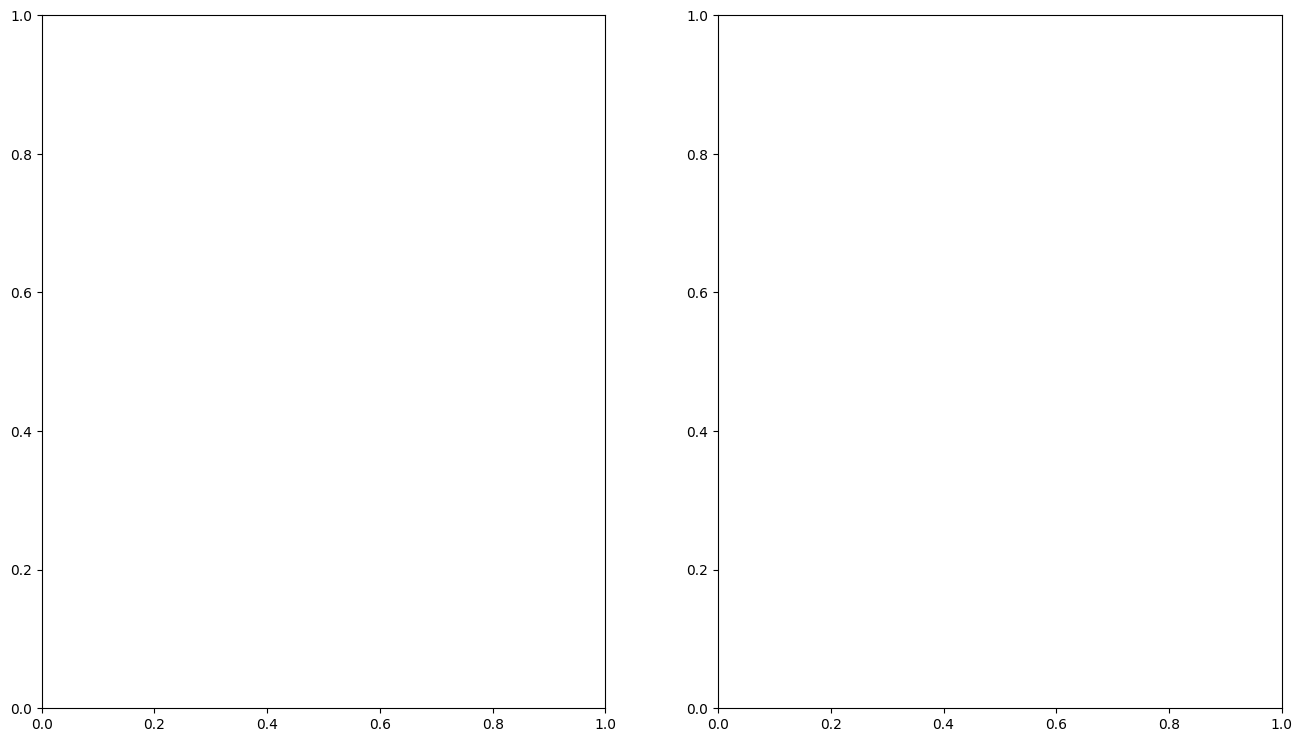

In [207]:
# Plot the results of the different sentiment annotations and add the manual annotations to the boxplot

# Create the subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 9))

# Boxplot for the original scores retrieved from the models
sns.boxplot(ax=axes[0], data=sampled_documents[models + ['flan','chat_gpt','sentiment_manual']])
axes[0].set_title('Original Sentiment Scores', fontsize=16)
axes[0].set_xlabel('Models', fontsize=12)
axes[0].set_ylabel('Sentiment Score', fontsize=12)
axes[0].tick_params(axis='x', rotation=90)

# Boxplot for the normalized scores
sns.boxplot(ax=axes[1], data=sampled_documents[[model + '_norm' for model in models] + ['flan','chat_gpt','sentiment_manual']])
axes[1].set_title('Continuous Sentiment Scores', fontsize=16)
axes[1].set_xlabel('Models', fontsize=12)
axes[1].set_ylabel('Categorical Sentiment Score', fontsize=12)
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

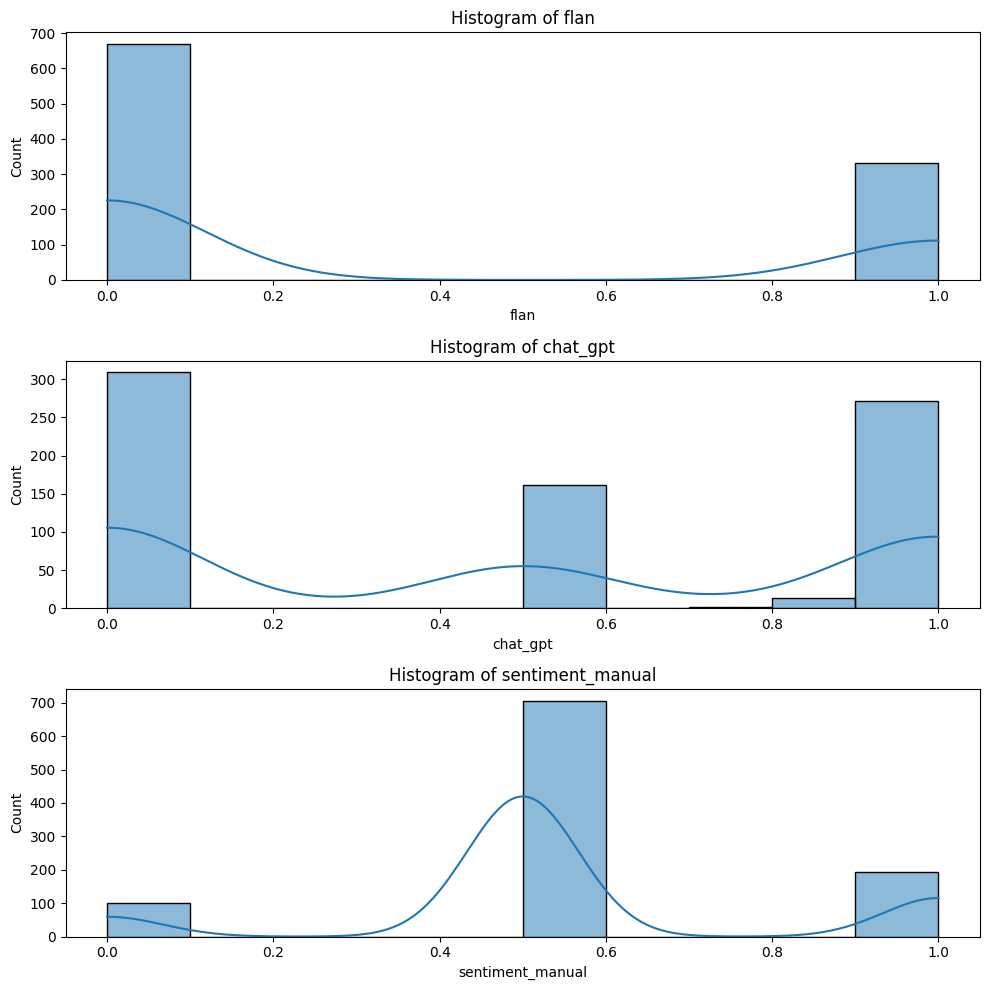

In [105]:
# Since multiple models just have 0.0, 0.5 and 1.0 as an output
df_hist = sampled_documents[['flan', 'chat_gpt', 'sentiment_manual']]

plt.figure(figsize=(10,10))
for i, col in enumerate(df_hist.columns):
    plt.subplot(3, 1, i+1)
    sns.histplot(df_hist[col], bins=10, kde=True)
    plt.title(f"Histogram of {col}")
    
plt.tight_layout()
plt.show()



From a processing speed perspective, the models differ in iterations per second (*it/s*):  

- cardiffnlp/twitter-roberta-base-sentiment:            25.5 it/s
- distilbert-base-uncased-finetuned-sst-2-english:      42.5 it/s
- Seethal/sentiment_analysis_generic_dataset:         45.0 it/s
- siebert/sentiment-roberta-large-english:              8.9 it/s
- nlptown/bert-base-multilingual-uncased-sentiment:     23.2 it/s
- google/flan-t5-base:                                  8.5 it/s
- GPT (via API):                                        1.5 it/s

*Seethal/sentiment_analysis_generic_dataset* is the fastest in terms of performance, *google/flan-t5-base* and *siebert/sentiment-roberta-large-english* are both around 8-9 it/s (slowest).  
Since *GPT* is called by an API, the processing speed is even slower with around 1.5 it/s. In addition it is costly, around 2$ for 1,000 sentences with the "text-davinci-003" mode.  
The models were tested on a Apple M1 Pro CPU with 10 cores and 32GB RAM.

The examination of different models for sentiment analysis has led to several noteworthy observations. Foremost among these is the superior performance of the Generative Pre-training Transformer (GPT) model in terms of congruence with our gold standard.  
This is corroborated by our quantitative and visual analyses, with both the boxplot mean values of *'chat_gpt'* and *'sentiment_manual'*, and the histogram comparisons substantiating the superior alignment of GPT outputs with the gold standard.

However, an important consideration in the context is the cost and computational efficiency associated with each model. Despite its promising performance, the GPT model necessitates an API call for each execution.  
This introduces a latency that substantially slows down the overall processing speed, making it less practical for annotating the full dataset within the given constraints.

Among the other models evaluated, the *'nlptown/bert-base-multilingual-uncased-sentiment'* model exhibits the most satisfactory performance. It has the smallest difference in mean value to 'sentiment_manual' compared to the rest of the models.  
Furthermore, its processing speed is commendably efficient, positioning it in the mid-range among the models tested.  
Consequently, this model strikes a balance between performance and computational efficiency, rendering it a suitable choice for our dataset annotation.

## Full Dataset Annotation with the selected LLM

Based on the comparison, *nlptown/bert-base-multilingual-uncased-sentiment* demonstrated best results to annotate the ESG documents.  
Therefore this LLM with a zero-shot / direct request strategy is used to annotate all sentences.

In [106]:
# Craete new column to store the sentence sentiment
documents['sentiment_llm'] = np.nan

In [ ]:
from transformers import pipeline
import numpy as np

def get_sentiment_scores(nlp, sentences):
    results = nlp(sentences)
    scores = [result['score'] for result in results]
    return scores

nlp_full = pipeline('sentiment-analysis', model='nlptown/bert-base-multilingual-uncased-sentiment', use_fast=True, truncation=True) # Model supports max. 512 tokens

# Define batch size for the processing
batch_size = 1000

# Split the sentences into batches and get scores
scores = []
for i in tqdm(range(0, len(documents['sentence_tokens'].sample(1000)), batch_size), desc="Processing batches"):
    batch = documents['sentence_tokens'][i:i+batch_size].tolist()
    batch_scores = get_sentiment_scores(nlp_full, batch)
    scores.extend(batch_scores)

# Add scores to DataFrame
documents['sentiment_llm'] = scores

In [ ]:
# Check the calculated sentiment values with a histogram
plt.figure(figsize=(10,6))
sns.histplot(documents['sentiment_llm'], bins=10, kde=True)
plt.title('Distribution of calculated Sentiment Values by LLM')
plt.tight_layout()
plt.show()

In [ ]:
# Reduce output columns
documents_reduced = documents[['company','datatype','title','date','domain','esg_topics','internal','symbol','sentence_tokens','market_cap_in_usd_b','sector','industry','year_month' ,'year','month','sentiment_llm', 'original_index']]

# Group by the 'original_index' and aggregate the columns
documents_aggregated = documents_reduced.groupby('original_index').agg({
    # Use 'first' function for all columns except for 'sentence_tokens' and 'sentence_sentiment_value_llm'
    'company': 'first',  
    'datatype': 'first',  
    'title': 'first',  
    'date': 'first',  
    'domain': 'first',  
    'esg_topics': 'first',  
    'internal': 'first',  
    'symbol': 'first',  
    'sentence_tokens': list,  # Combine the 'sentence_tokens' into a list
    'market_cap_in_usd_b': 'first',  
    'sector': 'first',  
    'industry': 'first',  
    'year_month': 'first',  
    'year': 'first',  
    'month': 'first',  
    'sentiment_llm': lambda x: [i if pd.notnull(i) else np.nan for i in x]  # Combine the 'sentence_sentiment_value_llm' into a list, substituting NaN where no manual sentiment was added
})

# Reset the index
documents_aggregated = documents_aggregated.reset_index(drop=True)

In [ ]:
# Save the full annotations to CSV (whole dataframe is too big to store on GitHub, Google Drive link provided)
if not os.path.exists('./annotated/'):  # Check if the directory exists and create it if it doesn't
    os.makedirs('./annotated/')
documents_aggregated.to_csv(f'./annotated/full_llm_annotated.csv', index=False, sep='|')

To store the complete CSSV with the calculated sentiment values, Google Drive is used. The "gold_standart.csv" (1,000 manually annotated sentences) and the "full_llm_annotated.csv" can be found here:  
https://drive.google.com/drive/folders/1ATtCPPll6n_qvfMBu4ka84E3DZDS7d11